[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/heartcored98/Standalone-DeepLearning-Chemistry/blob/master/Lec04/Lec04_lipo_smiles_cnn_prediction.ipynb)

### Install miniconda and rdkit

In [ ]:
"""
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
"""


Predict Phisf Property Using CNN
=====================

So far, we predicted lipophilicity with simple molecular representation (fingerprint). This time, we would employ CNN architecture with SMILES representation.

(1) Prepare Dataset and Data Loader
----------------------------

Download Lipophilicity dataset from [MoleculeNet](http://moleculenet.ai/datasets-1) Benchmark dataset.  
You can download from the webpage or source_dataset file from the url directly. 

In [1]:
!wget -q "http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/Lipophilicity.csv" -O Lipophilicity.csv

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


def get_splitted_lipo_dataset_with_vocab(ratios=[0.8, 0.1, 0.1], seed=123):

    raw_data = pd.read_csv('Lipophilicity.csv') # Open original dataset
    smiles = raw_data['smiles']
    
    # Construct char-level vocabulary
    vocab = set()
    for mol in smiles:
        vocab.update(list(mol))
    vocab = sorted(vocab)
    char_to_ix = {char: i for i, char in enumerate(vocab)}
        
    train_val, test = train_test_split(raw_data, test_size=ratios[2], random_state=seed)
    train, val = train_test_split(train_val, test_size=ratios[1]/(ratios[0]+ratios[1]), random_state=seed)
    
    return [train, val, test], vocab

datasets, vocab = get_splitted_lipo_dataset_with_vocab()
print("Vocab Size : total {} characters".format(len(vocab)))

Vocab Size : total 40 characters


In [2]:
from torch.utils.data import Dataset, DataLoader

class cnnDataset(Dataset):
    def __init__(self, df, vocab, max_len=120):
        self.smiles = df["smiles"]
        self.exp = df["exp"].values
        self.vocab = vocab 
        
        self.X = np.zeros((len(self.smiles), max_len))
                
        char_to_ix = {char: i for i, char in enumerate(self.vocab)}

        for i, smiles in enumerate(self.smiles):
            for j, char in enumerate(smiles[:max_len]):
                self.X[i][j] = char_to_ix[char] + 1 # zero-index for empty position
        
    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, index):
        return self.X[index], self.exp[index]

(2) Model Construction
----------------------------

CNN 기반의 Lipophilicity 예측 아키텍쳐를 구현하여 봅시다. 이를 위해 크게 두가지의 Module을 구현하고 사용합니다.  

- **ResBlock** 2D input을 받아서 Convolution하는 module입니다.  
- **CNNNet** mol 입력을 받아서 embedding으로 변환한 뒤 ResBlock등을 통과시키고 Molecular vector를 바탕으로 최종 Y값을 예측하는 module입니다.  

위 모듈들을 사용하여 CNNNet을 구현해봅시다.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim


class ResBlock(nn.Module):
    def __init__(self, in_filter, out_filter, stride, use_bn, dp_rate, block_type):
        super(ResBlock, self).__init__()   
        self.use_bn = use_bn
        self.block_type = block_type
        self.conv1 = nn.Conv2d(in_filter, out_filter, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_filter, out_filter, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(out_filter)
        self.bn2 = nn.BatchNorm2d(out_filter)
        self.dropout = nn.Dropout2d(dp_rate)
        self.shortcut = nn.Sequential()
        if in_filter != out_filter:
            self.shortcut.add_module(
                'conv', nn.Conv2d(in_filter, out_filter,
                                  kernel_size=1, stride=stride, 
                                  padding=0, bias=False)
            )
        
    def forward(self, _x):
        if self.block_type == 'a': #original residual block
            x = self.relu(self.bn1(self.conv1(_x))) if self.use_bn else self.relu(self.conv1(_x))
            x = self.bn2(self.conv2(x)) if self.use_bn else self.conv2(x)
            x = x + self.shortcut(_x)
            return self.dropout(self.relu(x))
        
        elif self.block_type == 'b': # BN after addition
            x = self.relu(self.bn1(self.conv1(_x))) if self.use_bn else self.relu(self.conv1(_x))
            x = self.conv2(x) + self.shortcut(_x)
            return self.dropout(self.relu(self.bn2(x)) if self.use_bn else self.relu(x))
        
        elif self.block_type == 'c': # ReLU before addition
            x = self.relu(self.bn1(self.conv1(_x))) if self.use_bn else self.relu(self.conv1(_x))
            x = self.relu(self.bn2(self.conv2(x))) if self.use_bn else self.relu(self.conv2(x))
            return self.dropout(x + self.shortcut(_x))
        
        elif self.block_type == 'd': # ReLU-only pre-activation
            x = self.bn1(self.conv1(self.relu(_x))) if self.use_bn else self.conv1(self.relu(_x))
            x = self.bn2(self.conv2(self.relu(x))) if self.use_bn else self.conv2(self.relu(x))
            return self.dropout(x + self.shortcut(_x))
        
        elif self.block_type == 'e': # full pre-activation
            x = self.conv1(self.relu(self.bn1(_x))) if self.use_bn else self.conv1(self.relu(_x))
            x = self.conv2(self.relu(self.bn2(x))) if self.use_bn else self.conv2(self.relu(x))
            return self.dropout(x + self.shortcut(_x))
             

class Net(nn.Module):
    def __init__(self, args):
        super(Net, self).__init__()   
        
        # Create Atom Element embedding layer
        self.embedding = self.create_emb_layer(args.vocab_size, args.emb_train)
        
        # Create Residual Convolution layer
        list_res_blocks = list()
        n_channel = 1
        for i in range(args.n_stage):
            if i==0:
                list_res_blocks.append(ResBlock(n_channel, n_channel*args.start_channel, args.stride, args.use_bn, args.dp_rate, args.block_type))
                n_channel *= args.start_channel
            else:
                list_res_blocks.append(ResBlock(n_channel, n_channel*2, args.stride, args.use_bn, args.dp_rate, args.block_type))
                n_channel *= 2
            for j in range(args.n_layer-1):
                list_res_blocks.append(ResBlock(n_channel, n_channel, 1, args.use_bn, args.dp_rate, args.block_type))
        self.res_blocks = nn.Sequential(*list_res_blocks)
        
        # Create MLP layers
        fc_shape = self._estimate_fc_shape((1, args.max_len,))
        self.fc1 = nn.Linear(fc_shape[-1], 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)
        self.relu = nn.ReLU()

    def create_emb_layer(self, vocab_size, emb_train):
        emb_layer = nn.Embedding(vocab_size, vocab_size)
        weight_matrix = torch.zeros((vocab_size, vocab_size))
        for i in range(vocab_size):
            weight_matrix[i][i] = 1
        emb_layer.load_state_dict({'weight': weight_matrix})

        if not emb_train:
            emb_layer.weight.requires_grad = False
        return emb_layer

    def _estimate_fc_shape(self, input_shape):
        dummy_input = torch.zeros(input_shape).long()
        dummy_output = self._conv_forward(dummy_input)
        fc_shape = dummy_output.view(dummy_output.shape[0], -1).shape
        return fc_shape   
    
    def _conv_forward(self, x):
        embeds = self.embedding(x)
        embeds = embeds.view(embeds.shape[0], 1, embeds.shape[1], embeds.shape[2])
        x = self.res_blocks(embeds)
        return x
    
    def forward(self, x):
        x = self._conv_forward(x)    
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.squeeze(x)

(3) Train, Validation, Test
----------------------------

Data, Model, Loss, Optimization을 모두 같이 사용하여 봅시다. 

Epoch 별로 train과 validation, test가 이루어질 수 있게 함수를 나누었습니다. 

In [4]:
def train(model, dataloader, optimizer, criterion, args, **kwargs):
    
    epoch_train_loss = 0
    list_train_loss = list()
    cnt_iter = 0
    for batch_idx, batch in enumerate(dataloader):
        X, y = batch[0].long(), batch[1].float()
        X, y = X.to(args.device), y.to(args.device)
    
        model.train()
        optimizer.zero_grad()

        pred_y = model(X)        
        train_loss = criterion(pred_y, y)
        epoch_train_loss += train_loss.item()
        list_train_loss.append({'epoch':batch_idx/len(dataloader)+kwargs['epoch'], 'train_loss':train_loss.item()})
        train_loss.backward()
        optimizer.step()
        
        cnt_iter += 1
    return model, list_train_loss


def validate(model, dataloader, criterion, args):
    
    epoch_val_loss = 0
    cnt_iter = 0
    for batch_idx, batch in enumerate(dataloader):
        X, y = batch[0].long(), batch[1].float()
        X, y = X.to(args.device), y.to(args.device)
    
        model.eval()
        pred_y = model(X)
        val_loss = criterion(pred_y, y)
        epoch_val_loss += val_loss.item()
        cnt_iter += 1

    return epoch_val_loss/cnt_iter

def test(model, dataloader, args, **kwargs):

    list_y, list_pred_y = list(), list()
    for batch_idx, batch in enumerate(dataloader):
        X, y = batch[0].long(), batch[1].float()
        X, y = X.to(args.device), y.to(args.device)
    
        model.eval()
        pred_y = model(X)
        list_y += y.cpu().detach().numpy().tolist()
        list_pred_y += pred_y.cpu().detach().numpy().tolist()

    mae = mean_absolute_error(list_y, list_pred_y)
    std = np.std(np.array(list_y)-np.array(list_pred_y))
    return mae, std, list_y, list_pred_y


def experiment(partition, args):
    ts = time.time()
    args.input_shape = (args.max_len, args.vocab_size)
    
    model = Net(args)
    
    model.to(args.device)
    criterion = nn.MSELoss()
    
    # Initialize Optimizer
    trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
    if args.optim == 'ADAM':
        optimizer = optim.Adam(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'RMSProp':
        optimizer = optim.RMSprop(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    else:
        assert False, "Undefined Optimizer Type"
        
    # Train, Validate, Evaluate
    list_train_loss = list()
    list_val_loss = list()
    list_mae = list()
    list_std = list()
    
    args.best_mae = 10000
    for epoch in range(args.epoch):
        model, train_losses = train(model, partition['train'], optimizer, criterion, args, **{'epoch':epoch})
        val_loss = validate(model, partition['val'], criterion, args)
        mae, std, true_y, pred_y = test(model, partition['test'], args, **{'epoch':epoch})
        
        list_train_loss += train_losses
        list_val_loss.append({'epoch':epoch, 'val_loss':val_loss})
        list_mae.append({'epoch':epoch, 'mae':mae})
        list_std.append({'epoch':epoch, 'std':std})
        
        if args.best_mae > mae or epoch==0:
            args.best_epoch = epoch
            args.best_mae = mae
            args.best_std = std
            args.best_true_y = true_y
            args.best_pred_y = pred_y
            

    # End of experiments
    te = time.time()
    args.elapsed = te-ts
    args.train_losses = list_train_loss
    args.val_losses = list_val_loss
    args.maes = list_mae
    args.stds = list_std

    return model, args 

(4) Experiment
----------------------------

Download Lipophilicity dataset from [MoleculeNet](http://moleculenet.ai/datasets-1) Benchmark dataset.  
You can download from the webpage or source_dataset file from the url directly. 

In [ ]:
import argparse
import time 
from sklearn.metrics import mean_absolute_error
from utils import *

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.vocab_size = len(vocab) + 1
args.max_len = 70

args.n_layer = 1
args.n_stage = 3

args.lr = 0.00005
args.l2_coef = 0.0001
args.optim = 'ADAM'
args.epoch = 100
args.test_batch_size= 128
args.emb_train = False
args.start_channel = 64
args.stride = 2
args.use_bn = True
args.dp_rate = 0.3
args.block_type = 'a'
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 256
args.exp_name = 'exp1_lr_stage'


writer = Writer(prior_keyword=['n_layer', 'n_stage','block_type', 'use_bn', 'lr', 'dp_rate', 'emb_train', 'epoch', 'batch_size'])
#writer.clear()

# Define Hyperparameter Search Space
list_lr = [0.001, 0.005, 0.025]
list_n_stage = [1,2,3,4,5]


train_dataloader = DataLoader(cnnDataset(datasets[0], vocab, args.max_len), batch_size=args.batch_size, shuffle=True)
val_dataloader = DataLoader(cnnDataset(datasets[1], vocab, args.max_len), batch_size=args.batch_size, shuffle=False)
test_dataloader = DataLoader(cnnDataset(datasets[2], vocab, args.max_len), batch_size=args.batch_size, shuffle=False)
partition = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

cnt_exp = 0
for lr in list_lr:
    for n_stage in list_n_stage:
        args.lr = lr
        args.n_stage = n_stage

        model, result = experiment(partition, args)
        writer.write(result)
        
        cnt_exp += 1        
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2}'.format(cnt_exp, result.best_mae, result.best_std, result.best_epoch))




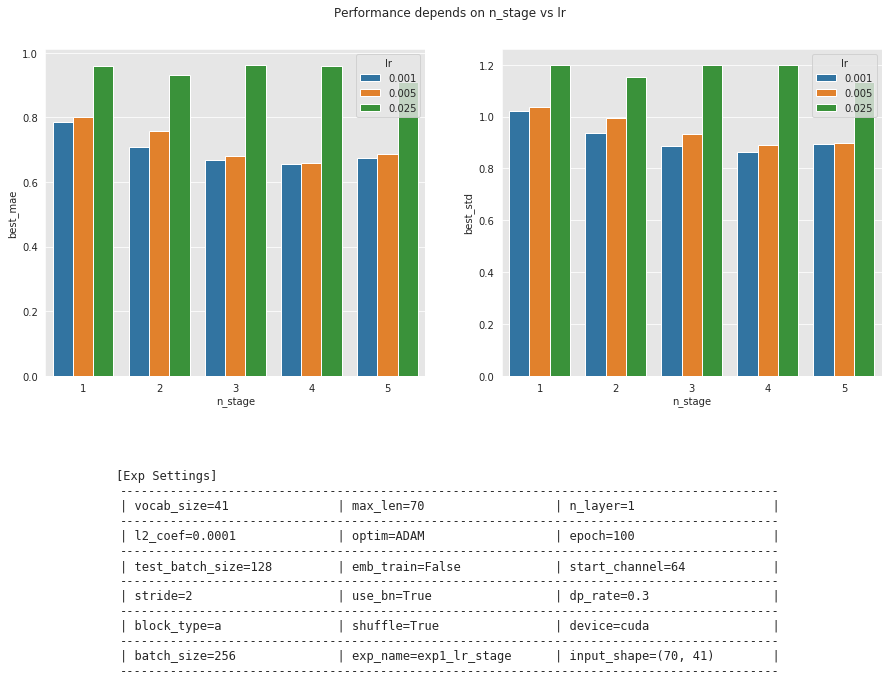

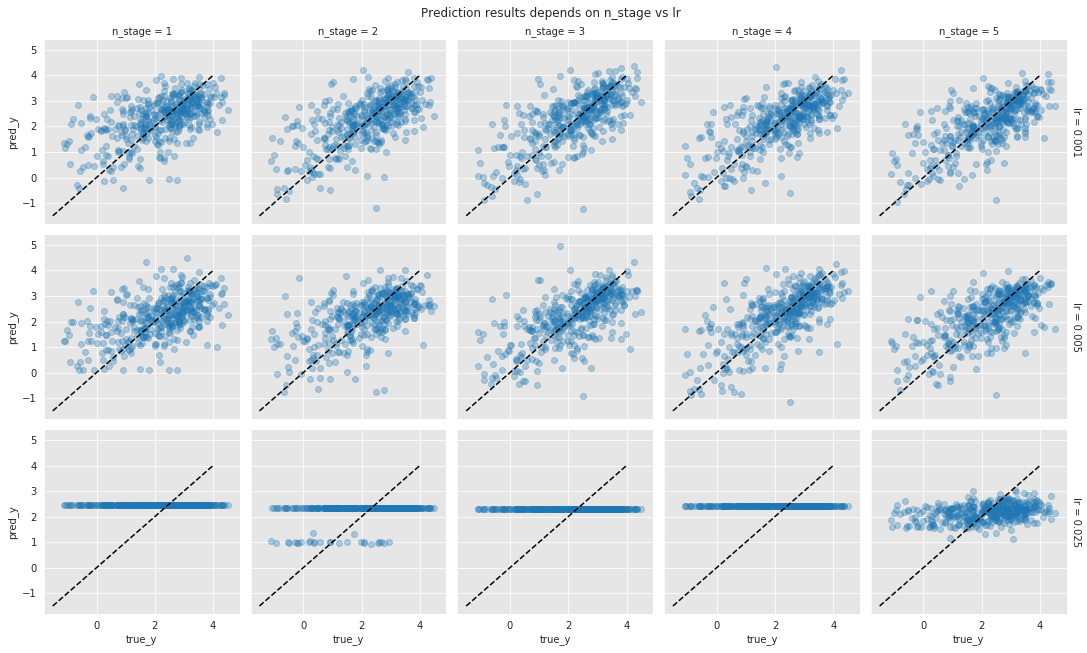

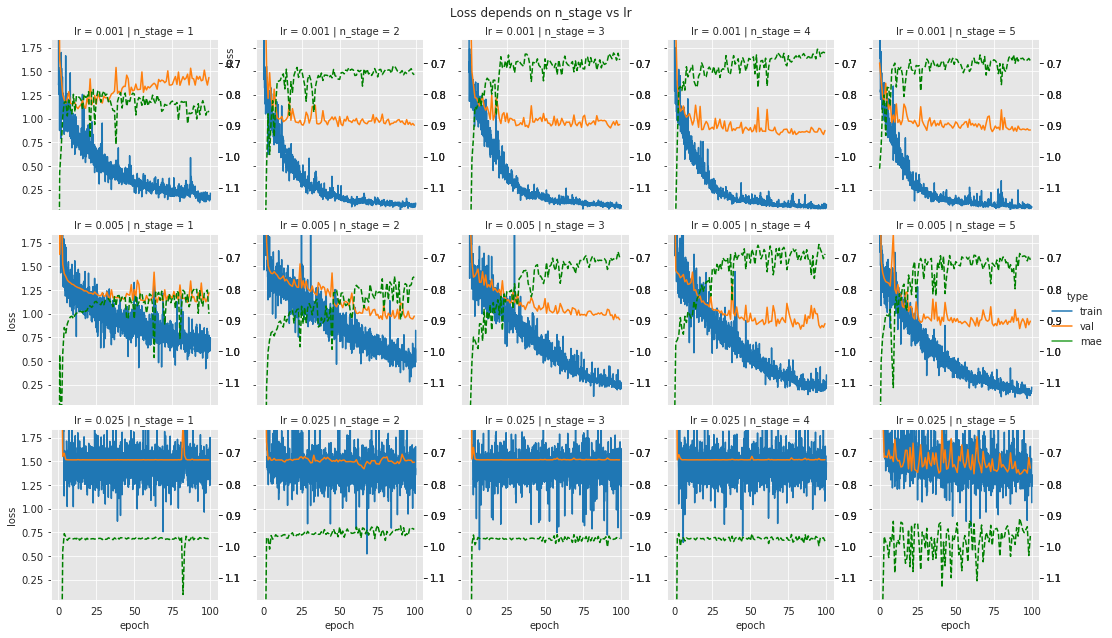

In [9]:
results = writer.read(exp_name='exp1_lr_stage')
#results = results.loc[results['epoch']==50]
variable1 = 'n_stage'
variable2 = 'lr'


plot_performance(results, variable1, variable2, args,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp1_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Prediction {} vs {}'.format(variable1, variable2))

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Loss {} vs {}'.format(variable1, variable2))

plt.show()